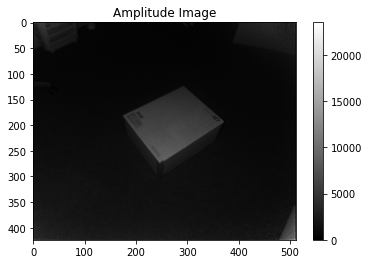

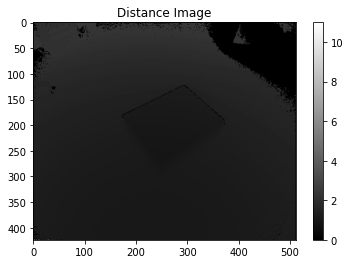

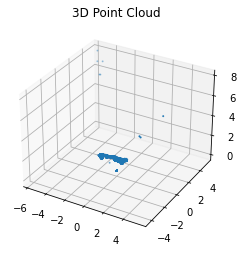

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to load data
def load_data(file_path):
    # Load .mat file
    data = scipy.io.loadmat(file_path)
    return data[list(data.keys())[3]], data[list(data.keys())[4]], data[list(data.keys())[5]]

# Accessing the amplitude image, distance image, and point cloud
A, D, PC = load_data('data/example3kinect.mat')

# Visualize the amplitude and distance images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(A[:, :, 0], cmap='gray')  # Assuming first channel if multiple
plt.title('Amplitude Image')
plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray')
plt.title('Distance Image')
plt.show()

# Visualizing the point cloud data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = PC[:, :, 0], PC[:, :, 1], PC[:, :, 2]
ax.scatter(x, y, z)
ax.set_title('3D Point Cloud')
plt.show()